In [2]:
import itertools
import more_itertools
import random
import matplotlib.pyplot as plt

from statistics import mean
from matplotlib.ticker import MaxNLocator

from analytics_clustering import *
from analytics_helper_clustering import *
from analytics import *
from analytics_helper import *
from common import *

In [3]:
# hides warnings - these do not affect code functionality

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
random.seed(3888)

In [5]:
# reading in all data
covid = read_live_covid_data()
countries_data = integrate_all_data(covid)

# Clustering

Mean silhouette score across

- 100 randomly-chosen interest combinations, and
- all possible region combinations.

In [6]:
scores = []

In [7]:
# randomly choosing 100 interest combinations
# each interest combination is essentially a list of 15 Booleans, 1 per interest
# each list of Booleans is used to create an interested dict two code blocks down

interest_combs = list(itertools.product([False, True], repeat=15))

interests = ["covid", 
             "infrastructure_quality_and_availability",
             "health_and_safety",
             "cost",
             "fun",
             "nature",
             "food",
             "museums",
             "showstheatresandmusic",
             "wellness",
             "wildlife"]

interest_combs_chosen = random.sample(interest_combs, 100)

while [False] * 15 in interest_combs_chosen:
    interest_combs_chosen = random.sample(interest_combs, 100)

In [8]:
# generating all region combinations

region_combs = list(more_itertools.powerset(['Asia-Pacific', 'Europe and Africa', 'Americas']))

In [9]:
for interest_comb in interest_combs_chosen:  
    for regions in region_combs:
        # generating the interested dict corresponding to the given interest combination, interest_comb
        interested = {}
        for i, interest in enumerate(interests):
            interested[interest] = interest_comb[i]

        # computing silhouette score, for given sets of interests and regions
        if list(interested.values()).count(True) != 0 and len(regions) != 0:
            weightings = convert_interests_to_col_weightings(interested)
            medians_scaled_pca, medians_scaled = prepare_data_for_clustering(countries_data, regions, weightings)

            scores.append(compute_silhouette_score(medians_scaled_pca))

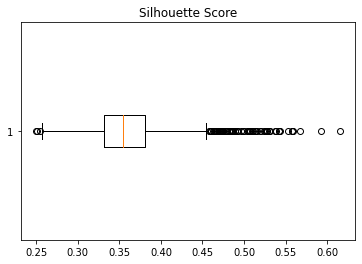

In [10]:
# plotting silhouette scores across interest and region combinations

fig1, ax1 = plt.subplots()
ax1.set_title('Silhouette Score')
ax1.boxplot(scores, vert=False)
plt.show()

In [11]:
mean(scores)

0.3667315449917928

**Observation:** Our silhouette score is average; there is _some_ clustering structure in our data, though it is not very well-defined.

However, for our purposes, it doesn't really matter whether our clusters are _extremely_ well-defined or not; either way, each cluster will still be a group of fairly-similar countries.

# k-NN

In [12]:
num_neighbours = 10

In [13]:
iso_location = read_iso_loc_data()

In [14]:
# randomly selecting 3 interest combinations (only 3 to save time - more takes too long to run)

interest_combs_10NN = list(more_itertools.powerset(interests))

interest_combs_10NN_chosen = random.sample(interest_combs_10NN, 3)

while [False] * 15 in interest_combs_chosen:
    interest_combs_chosen = random.sample(interest_combs, 3)
    
print("chosen_interests:")
interest_combs_10NN_chosen

chosen_interests:


[('covid',
  'infrastructure_quality_and_availability',
  'health_and_safety',
  'nature',
  'museums',
  'showstheatresandmusic',
  'wellness',
  'wildlife'),
 ('covid',),
 ('fun', 'nature', 'food', 'wellness')]

In [15]:
# randomly choosing 5 countries

countries_10NN_chosen = random.sample(list(iso_location['location'].drop_duplicates()), 5)

print("chosen_countries:")
countries_10NN_chosen

chosen_countries:


['Slovenia', 'Lithuania', 'Colombia', 'Vietnam', 'Norway']

In [16]:
all_metrics = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
               'cosine', 'euclidean', 'manhattan', 'minkowski']

## Single model

1. We randomly choose 3 interest combinations, $\text{chosen_interests}$.
2. We randomly choose 5 countries, $\text{chosen_countries}$.
3. For each pair of distance metrics $d_1, d_2$:
    - For each $i$ in $\text{chosen_interests}$:
        - For each $c$ in $\text{chosen_countries}$:
            - we compute proportion of similarity between sets of countries produced by 
                - 10-NN for $c$ when $d_1$ is used as distance metric (with columns in $i$ weighted more), and 
                - 10-NN for $c$ when $d_2$ is used as distance metric (with columns in $i$ weighted more).
5. We compute the average $a$ of all proportion of similarity values.

In [17]:
# computing all metrics pairs

metrics_pairs = list(itertools.combinations(all_metrics, r=2))

In [18]:
prop_similarity = []

for pair in metrics_pairs:
    regions = ['Asia-Pacific', 'Europe and Africa', 'Americas']
    
    for interests in interest_combs_10NN_chosen:  
    
        if len(interests) > 0 and len(regions) > 0:
            continents = convert_regions_to_continents(regions)

            cols_of_interest = convert_interests_to_cols(interests)
            weightings = generate_feature_weightings_dict(cols_of_interest)

            for country in countries_10NN_chosen:  
                medians_scaled, medians, data_no_quant = prepare_data_for_nn(countries_data, country, continents, weightings)

                if not loc_to_iso_code(country, iso_location) in medians.index:
                    continue

                # computing neighbour set if distance metric used is pair[0]
                neighbours_all_metrics = list(generate_final_df_w_nn(country,
                                                                 medians_scaled,
                                                                 medians,
                                                                 data_no_quant,
                                                                 num_neighbours = num_neighbours,
                                                                 dist_metrics=[pair[0]])['10NN'])[0]

                # computing neighbour set if distance metric used is pair[1]
                neighbours_metric_missing = list(generate_final_df_w_nn(country,
                                                                 medians_scaled,
                                                                 medians,
                                                                 data_no_quant,
                                                                 num_neighbours = num_neighbours,
                                                                 dist_metrics=[pair[1]])['10NN'])[0]

                # computing intersection of the two neighbour sets
                neighbours_intersect = set(neighbours_all_metrics).intersection(neighbours_metric_missing)   
                
                # computing proportion of neighbours shared between both sets
                sim = len(neighbours_intersect)/num_neighbours

                prop_similarity.append(sim)

In [19]:
mean(prop_similarity)

0.6209259259259259

**Observation:** Changing our distance metric leads to a _non-negligible change in result_ (on average) - our model is not very stable, not robust to change in distance metric.

**Solution:** Use an ensemble. Each model in ensemble is a 10-NN model using a *different distance metric*.

## Ensemble

1. We randomly choose 3 interest combinations, $\text{chosen_interests}$.
2. We randomly choose 5 countries, $\text{chosen_countries}$.
3. For each distance metric $d$:
    - For each $i$ in $\text{chosen_interests}$:
        - For each $c$ in $\text{chosen_countries}$:
            - we compute the proportion of similarity between sets of countries returned by
                - 10-NN for $c$ with full ensemble (and with columns in $i$ weighted more), and
                - 10-NN for $c$ with full ensemble **minus $d$** (and with columns in $i$ weighted more).
    - We compute the average $a$ of all the proportion of similarity values corresponding to $d$. $a$ becomes the overall "score" for $d$.

In [20]:
prop_similarity = {}

for metric in all_metrics:
    dist_metrics = list(set(all_metrics) - set([metric]))
    regions = ['Asia-Pacific', 'Europe and Africa', 'Americas']
    
    for interests in interest_combs_10NN_chosen:  
    
        if len(interests) > 0 and len(regions) > 0:
            continents = convert_regions_to_continents(regions)

            cols_of_interest = convert_interests_to_cols(interests)
            weightings = generate_feature_weightings_dict(cols_of_interest)

            for country in countries_10NN_chosen:  
                medians_scaled, medians, data_no_quant = prepare_data_for_nn(countries_data, country, continents, weightings)

                if not loc_to_iso_code(country, iso_location) in medians.index:
                    continue

                # computing neighbour set using all metrics
                neighbours_all_metrics = list(generate_final_df_w_nn(country,
                                                                 medians_scaled,
                                                                 medians,
                                                                 data_no_quant,
                                                                 num_neighbours = num_neighbours,
                                                                 dist_metrics=all_metrics)['10NN'])[0]

                # computing neighbour set using all metrics except "metric"
                neighbours_metric_missing = list(generate_final_df_w_nn(country,
                                                                 medians_scaled,
                                                                 medians,
                                                                 data_no_quant,
                                                                 num_neighbours = num_neighbours,
                                                                 dist_metrics=dist_metrics)['10NN'])[0]

                # computing intersection of the two neighbour sets
                neighbours_intersect = set(neighbours_all_metrics).intersection(neighbours_metric_missing)    

                
                # computing proportion of neighbours shared between both sets
                sim = len(neighbours_intersect)/num_neighbours

                if not metric in prop_similarity:
                    prop_similarity[metric] = [sim]
                else:
                    prop_similarity[metric].append(sim)

In [21]:
# computing average proportion of similarity, per metric

avg_prop_similarity = {}

for metric in prop_similarity.keys():
    avg_prop_similarity[metric] = mean(prop_similarity[metric])

In [22]:
avg_prop_similarity

{'braycurtis': 0.9466666666666667,
 'canberra': 0.9666666666666667,
 'chebyshev': 0.9866666666666667,
 'cityblock': 0.9733333333333334,
 'correlation': 0.9933333333333333,
 'cosine': 0.9666666666666667,
 'euclidean': 0.9933333333333333,
 'manhattan': 0.9733333333333334,
 'minkowski': 0.9933333333333333}

In [23]:
sim_vals = list(avg_prop_similarity.values())

In [24]:
sim_vals

[0.9466666666666667,
 0.9666666666666667,
 0.9866666666666667,
 0.9733333333333334,
 0.9933333333333333,
 0.9666666666666667,
 0.9933333333333333,
 0.9733333333333334,
 0.9933333333333333]

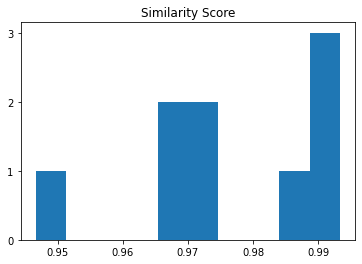

In [28]:
# plotting similarity scores across interest and country combinations

fig2, ax2 = plt.subplots()
ax2.set_title('Similarity Score')
ax2.hist(sim_vals)
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

In [26]:
#example of one case of similarity testing for the ensemble
results = {}

for metric in all_metrics:
    dist_metrics = list(set(all_metrics) - set([metric]))
    regions = ['Asia-Pacific', 'Europe and Africa', 'Americas']
    
    #for interests in interest_combs_10NN_chosen:  
    interest = interest_combs_10NN_chosen[1]

    if len(interests) > 0 and len(regions) > 0:
        continents = convert_regions_to_continents(regions)

        cols_of_interest = convert_interests_to_cols(interests)
        weightings = generate_feature_weightings_dict(cols_of_interest)
        
        country = countries_10NN_chosen[3]
        #for country[0] in countries_10NN_chosen:  
        medians_scaled, medians, data_no_quant = prepare_data_for_nn(countries_data, country, continents, weightings)

        if not loc_to_iso_code(country, iso_location) in medians.index:
            continue

        # computing neighbour set using all metrics
        neighbours_all_metrics = list(generate_final_df_w_nn(country,
                                                         medians_scaled,
                                                         medians,
                                                         data_no_quant,
                                                         num_neighbours = num_neighbours,
                                                         dist_metrics=all_metrics)['10NN'])[0]

        # computing neighbour set using all metrics except "metric"
        neighbours_metric_missing = list(generate_final_df_w_nn(country,
                                                         medians_scaled,
                                                         medians,
                                                         data_no_quant,
                                                         num_neighbours = num_neighbours,
                                                         dist_metrics=dist_metrics)['10NN'])[0]

        # computing intersection of the two neighbour sets
        neighbours_intersect = set(neighbours_all_metrics).intersection(neighbours_metric_missing)    

        results[metric] = sorted(neighbours_metric_missing)

results["full_model"] = sorted(neighbours_all_metrics)

In [27]:
#the user inputs for this particular example
#randomly generated interest
print(interest)
#randomly generated country
print(country)

#dataframe displaying all results for the ensemble - both the full model and after the 
#removal of a distance metric
r = pd.DataFrame.from_dict(results)
r

('covid',)
Vietnam


,braycurtis,canberra,chebyshev,cityblock,correlation,cosine,euclidean,manhattan,minkowski,full_model
0,China,China,China,China,China,China,China,China,China,China
1,Colombia,Colombia,Colombia,Colombia,Colombia,Colombia,Colombia,Colombia,Colombia,Colombia
2,Costa Rica,Costa Rica,Costa Rica,Costa Rica,Costa Rica,Costa Rica,Costa Rica,Costa Rica,Costa Rica,Costa Rica
3,Indonesia,Indonesia,Indonesia,Indonesia,Indonesia,Indonesia,Indonesia,Indonesia,Indonesia,Indonesia
4,Malaysia,Malaysia,Malaysia,Malaysia,Malaysia,Malaysia,Malaysia,Malaysia,Malaysia,Malaysia
5,Peru,Peru,Peru,Peru,Peru,Peru,Peru,Peru,Peru,Peru
6,Russia,Russia,Russia,Russia,Russia,Russia,Russia,Russia,Russia,Russia
7,Sri Lanka,Sri Lanka,Sri Lanka,Sri Lanka,Sri Lanka,Sri Lanka,Sri Lanka,Sri Lanka,Sri Lanka,Sri Lanka
8,Taiwan,Taiwan,Taiwan,Taiwan,Taiwan,Taiwan,Taiwan,Taiwan,Taiwan,Taiwan
9,Thailand,Thailand,Thailand,Thailand,Thailand,Thailand,Thailand,Thailand,Thailand,Thailand


**Observation:** Removing any single model from ensemble leads to only a slight change in result. Thus, we ensure that *no one distance metric completely determines 10 nearest neighbours*, and so our model is very robust to removal/addition of distance metrics. Whereas when we used just 1 model/distance metric, changing the single distance metric used led to considerably more variability in result.